# Стартапы

## 0.Описание проекта

### 0.1.Задача проекта

Разработать модель для предсказания успешности стартапа (закроется или нет)

### 0.2.Описание данных

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

- kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Наша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
 - kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.
name - идентификатор (название) стартапа в тестовом наборе.
status - целевой признак. Для каждого стартапа необходимо предсказать категориальное значение соответствующее прогнозу ['operating', 'closed'].
 - worldcitiespop.csv - дополнитеьная информация о городах, получена тут - https://www.kaggle.com/datasets/max-mind/world-cities-database/data

### 0.3.Описание полей данных

- name - Название стартапа
- category_list - Список категорий, к которым относится стартап
- funding_total_usd - Общая сумма финансирования в USD
- status - Статус стартапа (закрыт или действующий)
- country_code - Код страны
- state_code - Код штата
- region - Регион
- city - Город
- funding_rounds - Количество раундов финансирования
- founded_at - Дата основания
- first_funding_at - Дата первого раунда финансирования
- last_funding_at - Дата последнего раунда финансирования
- closed_at - Дата закрытия стартапа (если применимо)
- lifetime - Время существования стартапа в днях

### 0.4.План выполения проекта

- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

## 1. Загрузка и подготовка данных

### 1.1. Чтение данных

In [75]:
# Установим необходимые библиотеки
!pip install phik
!pip install lightgbm
!pip install unidecode
!pip install shap
!pip install category_encoders
!pip install imbalanced-learn

In [76]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns

from datetime import datetime

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from category_encoders import CatBoostEncoder

from matplotlib.dates import DateFormatter, MonthLocator

from scipy import stats as st

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score, classification_report, make_scorer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import TargetEncoder, StandardScaler, MinMaxScaler, FunctionTransformer, LabelEncoder
from sklearn.pipeline import Pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from unidecode import unidecode

import phik
import shap
import os

pd.set_option('display.float_format', '{:.2f}'.format)

In [77]:
# Определим константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [78]:
# Загрузим данные
test = pd.read_csv('kaggle_startups_test_28062024.csv', parse_dates=['first_funding_at', 'last_funding_at'], index_col='name')
train = pd.read_csv('kaggle_startups_train_28062024.csv', parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'], index_col='name')
city = pd.read_csv('worldcitiespop.csv', low_memory=False)

In [79]:
# Проверим размеры получившихся датасетов
print(test.shape)
print(train.shape)
print(city.shape)

(13125, 10)
(52516, 12)
(3173958, 7)


### 1.2. Изучение общей информации о датасетах

In [80]:
# Создадим функцию для просмотра общей информации о датасетах
def overview_data(data):
    dash = '-' * 50

    print(dash)
    print('Основная информация о данных')
    print(dash)
    print(data.info())
    print('\n')

    print(dash)
    print('Первые строки данных')
    print(dash)
    print(data.head())
    print('\n')

    print(dash)
    print('Описательная статистика')
    print(dash)
    print(data.describe())
    print('\n')

    print(dash)
    print('Пропущенные значения')
    print(dash)
    print(data.isna().sum())
    print('\n')

    print(dash)
    print('Дубликаты')
    print(dash)
    print(data.duplicated().sum())
    print('\n')

In [81]:
# Выведем общую информацию о датасете train
overview_data(train)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 52516 entries, Lunchgate to Apparcando
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   category_list      50051 non-null  object        
 1   funding_total_usd  42447 non-null  float64       
 2   status             52516 non-null  object        
 3   country_code       47014 non-null  object        
 4   state_code         45753 non-null  object        
 5   region             46157 non-null  object        
 6   city               46157 non-null  object        
 7   funding_rounds     52516 non-null  int64         
 8   founded_at         52516 non-null  datetime64[ns]
 9   first_funding_at   52516 non-null  datetime64[ns]
 10  last_funding_at    52516 non-null  datetime64[ns]
 11  closed_at          4917 non-null

In [82]:
# Выведем общую информацию о датасете train
overview_data(test)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, Crystalsol to RingCentral
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   category_list      12534 non-null  object        
 1   funding_total_usd  10547 non-null  float64       
 2   country_code       11743 non-null  object        
 3   state_code         11430 non-null  object        
 4   region             11536 non-null  object        
 5   city               11538 non-null  object        
 6   funding_rounds     13125 non-null  int64         
 7   first_funding_at   13125 non-null  datetime64[ns]
 8   last_funding_at    13125 non-null  datetime64[ns]
 9   lifetime           13125 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(2), object(5)
memory usage: 1.1+ MB
None


--

In [83]:
overview_data(city)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173958 entries, 0 to 3173957
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Country     object 
 1   City        object 
 2   AccentCity  object 
 3   Region      object 
 4   Population  float64
 5   Latitude    float64
 6   Longitude   float64
dtypes: float64(3), object(4)
memory usage: 169.5+ MB
None


--------------------------------------------------
Первые строки данных
--------------------------------------------------
  Country        City  AccentCity Region  Population  Latitude  Longitude
0      ad       aixas       Aixàs     06         NaN     42.48       1.47
1      ad  aixirivali  Aixirivali     06         NaN     42.47       1.50
2      ad  aixirivall  Aixirivall     06         NaN     42.47       1.50
3      ad   aixirvall   Aixirvall     06         NaN

### Вывод

Датасет train
- в колонках funding_rounds, founded_at, first_funding_at, last_funding_at, closed_at, status пропусков нет
- в колонке name один пропуск
- в остальных колонках от 2465 до 47599 пропусков
- пропуски в колоне closed_at скорее всего вызваны тем что стартап все еще существует или тем, что он существовал на момент акутализации данных
- пропуски в колонке funding_total_usd скорее всего вызваны тем, что финансирования не было или данные утеряны
- в колонке funding_total_usd можно изменить формат на int т.к. думаю что центы в сумме финансирования не влияют на сумму
- явных дубликатов 10 - сразу удалим

Датасет test
- в колонках funding_rounds, first_funding_at, last_funding_at, status, name пропусков нет
- в остальных колонках от 591 до 2578 пропусков
- есть колонка lifetime - срок жизни стартапа, эту колонку нужно будет добавить в датасет train
- нет колонок founded_at и closed_at они заменены колонкой lifetime
- явных дубликатов 1 - удалять не будет т.к. выборка тестовая

Датасет city
- много пропусков в колонке с населением
- 311 дубликатов

In [84]:
## 2. Анализ признаков

In [85]:
# Сразу удалим дубликаты
train = train.drop_duplicates()

### 2.1. Анализ числовых признаков

In [86]:
# Функция построения диаграмм для числовых признаков
def num_diag(data, x, xlabel, ylabel, hue=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(
        data=data,
        x=x,
        hue=hue,
        ax=axes[0],
        stat="density",
        bins=20,
        common_norm=False
    )
    axes[0].set_title(f'Гистограмма по {xlabel}')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)

    sns.boxplot(
        data=data,
        x=x,
        ax=axes[1]
    )
    axes[1].set_title(f'Диаграмма размаха {xlabel}')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

In [87]:
# Функция построения диаграмм для категориальных признаков
def cat_diag(data, x, xlabel, hue=None, threshold=0.015):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    value_counts = data[x].value_counts(normalize=True)
    small_categories = value_counts[value_counts < threshold].index
    data_modified = data.copy()
    data_modified[x] = data_modified[x].apply(lambda val: 'Другие' if val in small_categories else val)

    sns.countplot(
        data=data_modified,
        x=x,
        hue=hue,
        ax=axes[0],
        order=data_modified[x].value_counts().index
    )
    axes[0].set_title(f'Диаграмма по {xlabel}')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(xlabel)
    axes[0].tick_params(axis='x', rotation=45)

    pie_data = data_modified[x].value_counts(normalize=True)

    pie_data.plot(
        kind='pie',
        labels=pie_data.index,
        legend=False,
        autopct='%1.0f%%',
        ax=axes[1],
        startangle=90,
        counterclock=False
    )
    axes[1].set_title(f'Распределение долей {xlabel}')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

In [88]:
# Создадим функцию для автоматической визуализации признаков в зависимости от типа колонки
def all_diag(df, column_type='numeric', hue=None):
    if column_type == 'numeric':
        columns = df.select_dtypes(include='number').columns
    elif column_type == 'categorical':
        columns = df.select_dtypes(include='object').columns

    for col in columns:
        if column_type == 'numeric':
            print(f"Визуализация численного признака: {col}")
            num_diag(df, x=col, xlabel=col, ylabel='Плотность распределения', hue=hue)
        elif column_type == 'categorical':
            print(f"Визуализация категориального признака: {col}")
            cat_diag(df, x=col, xlabel=col, hue=hue)

Визуализация численного признака: funding_total_usd


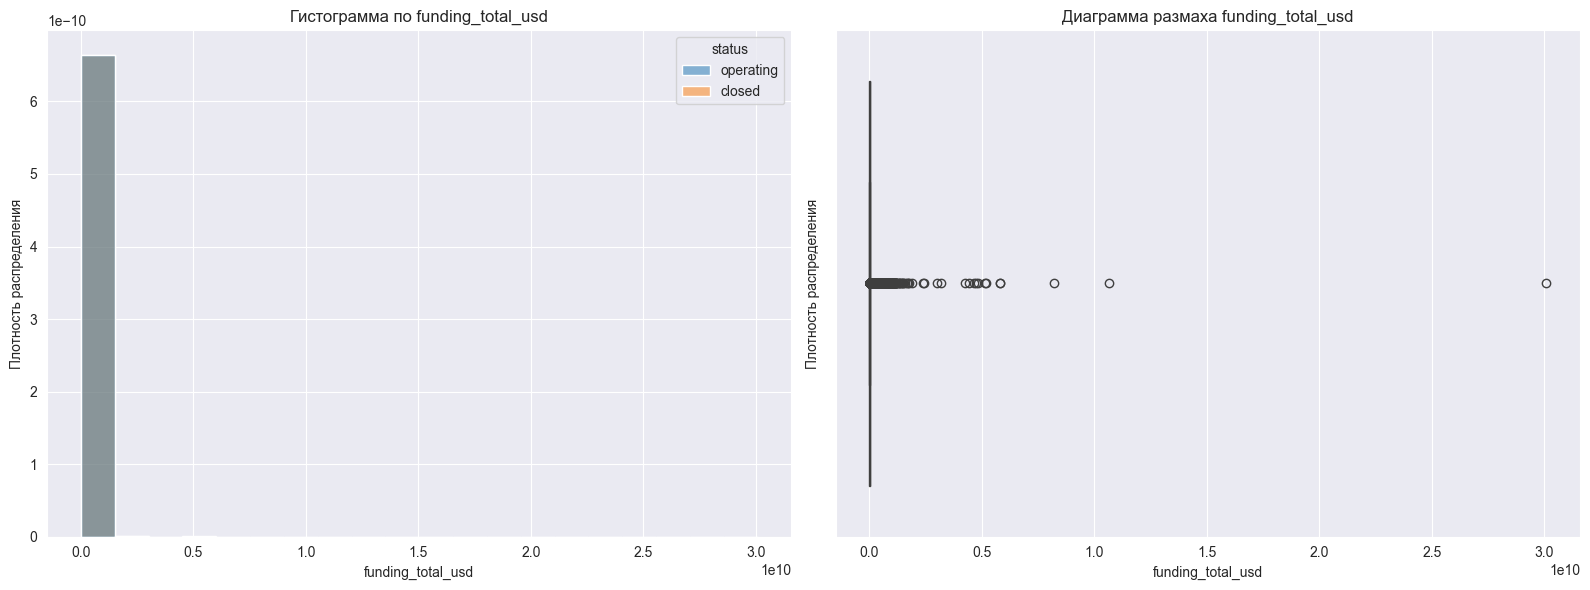

Визуализация численного признака: funding_rounds


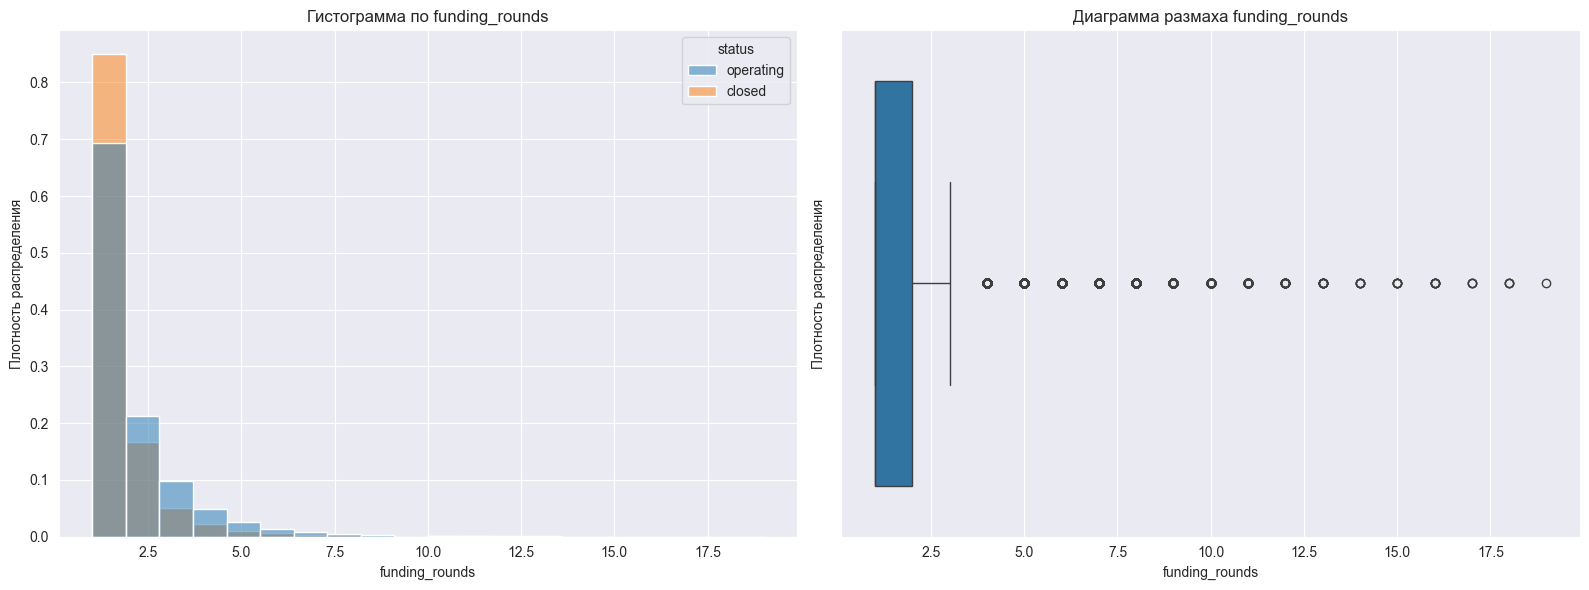

In [89]:
all_diag(train, column_type='numeric', hue='status')

In [90]:
train['funding_total_usd'].describe()

count         42445.00
mean       18248324.10
std       187121669.48
min               1.00
25%          336055.00
50%         2000000.00
75%        10000000.00
max     30079503000.00
Name: funding_total_usd, dtype: float64

In [91]:
# Посмотрим на самое большое финансирование
train[train['funding_total_usd'] > 3*10**10]

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
name,,,,,,,,,,,,
Verizon Communications,Communications Infrastructure|Information Tech...,30079503000.00,operating,USA,NY,New York City,New York,5,1983-10-07,2010-01-26,2014-02-28,NaT


Всего одна компания, такое финансирование исключение из правил.

In [92]:
# Посмотрим на финансирование менее 100 долларов
train[train['funding_total_usd'] < 100]

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
name,,,,,,,,,,,,
Leinentausch / LeashSwap,Pets,68.00,operating,DEU,16,Berlin,Berlin,2,2013-03-31,2014-04-01,2015-01-15,NaT
Snapstream,Software,50.00,operating,USA,GA,Atlanta,Marietta,1,2013-11-11,2013-11-09,2013-11-09,NaT
Stirling Power,Design,29.00,operating,USA,ND,ND - Other,Michigan,1,2002-11-20,2004-04-28,2004-04-28,NaT
Threatbutt,Animal Feed|Cyber Security|Data Security|Homel...,12.00,operating,USA,CA,SF Bay Area,Menlo Park,1,2015-04-20,2015-04-28,2015-04-28,NaT
Sentic Technologies Inc,Information Technology|Internet|SaaS|Search Ma...,1.00,operating,USA,IL,Chicago,Chicago,1,2014-02-01,2015-11-12,2015-11-12,NaT
BLUErabbit,Education|Educational Games|Game Mechanics|Gam...,70.00,operating,MEX,9,Mexico City,Mexico City,1,2014-06-16,2015-10-30,2015-10-30,NaT
Soundctl,Audio|Video Streaming,2.00,operating,USA,CA,SF Bay Area,Mountain View,1,2015-07-01,2015-09-23,2015-09-23,NaT
The Manly Man Can,Fashion,30.00,operating,USA,MI,Detroit,Pinckney,1,2014-10-26,2014-10-27,2014-10-27,NaT
Romo Wind,Innovation Engineering|Optimization|Services,5.00,operating,DEU,8,DEU - Other,Straße,1,2011-08-18,2013-04-26,2013-04-26,NaT


100 долларов - финансирование чисто номинальное, врядли такая сумма могла повлиять на успех стартапа.

funding_total_usd
- среднее значение финансирования составляет 18.2 млн.
- максимальное финансирование около 3 млрд. - думаю это реальное значение, было одно такое финасирование
- есть значение финансирования в 1 доллар
- большинство значений суммы финансирования находится в диапазоне между 336 тыс. и 10 млн

In [93]:
# Среднее финансирование закрытых стартапов
train[train['status'] == 'closed']['funding_total_usd'].mean()

11281157.461752674

In [94]:
# Среднее финансирование работающих стартапов
train[train['status'] == 'operating']['funding_total_usd'].mean()

18951673.063507523

У работающих стартапов среднее финансирование 1.5 раза больше. Чем больше денег тем больше шансов выжить у стартапа. Важный признак для модели.

In [95]:
train['funding_rounds'].describe()

count   52506.00
mean        1.74
std         1.37
min         1.00
25%         1.00
50%         1.00
75%         2.00
max        19.00
Name: funding_rounds, dtype: float64

In [96]:
# Посмотрим на компанию с 19 раундами финансирования
train[train['funding_rounds']==19]

,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
name,,,,,,,,,,,,
Solarflare Communications,Enterprise Software,242948825.00,operating,USA,CA,Anaheim,Irvine,19,2005-01-01,2005-02-28,2015-01-05,NaT


funding_rounds
- среднее значение раундов финансирования составляет 1.74 раунда
- максимальное количество раундов 19
- минимальное количество раундов 1
- большинство значений раундов финансирования 1-2 раунда, все что больше единичные значения
- закрытых проектов после 5-6 раундов финансирования практически нет, однако и проектов с таким количеством финанирования тоже практически нет.

### 2.2. Анализ категориальных признаков

Подготовим данные к анализу

In [97]:
# Посчитаем максимальное количество слов в категории
max_words = train['category_list'].str.split('|').apply(lambda x: max(len(s.split()) for s in x) if isinstance(x, list) else 0).max()
print(max_words)

5


In [98]:
# Создадим 5 колонок с категориями, если категории нет - устанавливаем значение other
def process_categories(df):
    df = df.copy()
    splitted = df['category_list'].str.split('|', expand=True).iloc[:, :5]
    col_names = [f'cat_{i+1}' for i in range(5)]
    df[col_names] = splitted.fillna('other')
    return df

In [99]:
# Применяем функцию к обоим датафреймам
split_train = process_categories(train)
split_test = process_categories(test)

In [100]:
# Проверка
print(train.shape)
print(split_train.shape)
print(test.shape)
print(split_test.shape)

(52506, 12)
(52506, 17)
(13125, 10)
(13125, 15)


In [101]:
# Проверим что все получилось
split_test.head()

,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_1,cat_2,cat_3,cat_4,cat_5
name,,,,,,,,,,,,,,,
Crystalsol,Clean Technology,2819200.00,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,Clean Technology,other,other,other,other
JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Hospitality,other,other,other,other
COINPLUS,Finance,428257.00,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance,other,other,other,other
Imagine Communications,Software|Video|Video Streaming,34700000.00,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,Software,Video,Video Streaming,other,other
DNA13,Software,4530000.00,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,Software,other,other,other,other


In [102]:
# Общая колонка с категориями нам больше не нужна, удалим ее
split_train = split_train.drop(columns='category_list')
split_test = split_test.drop(columns='category_list')

Визуализация категориального признака: status


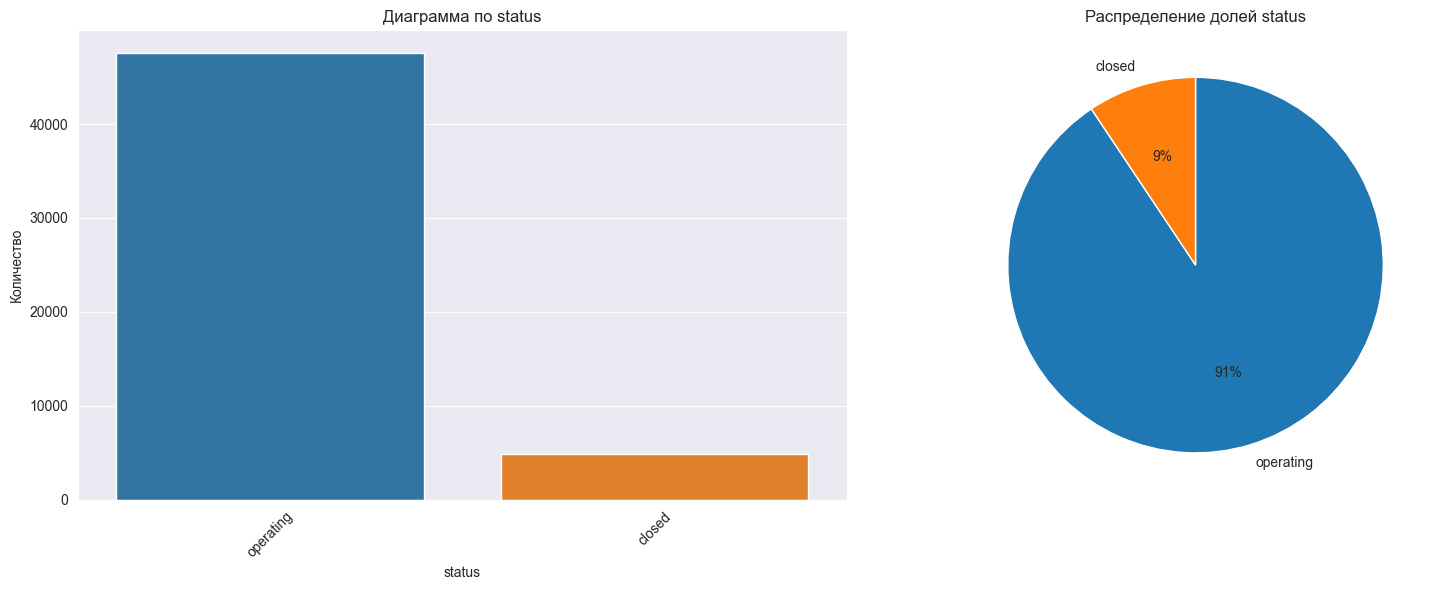

Визуализация категориального признака: country_code


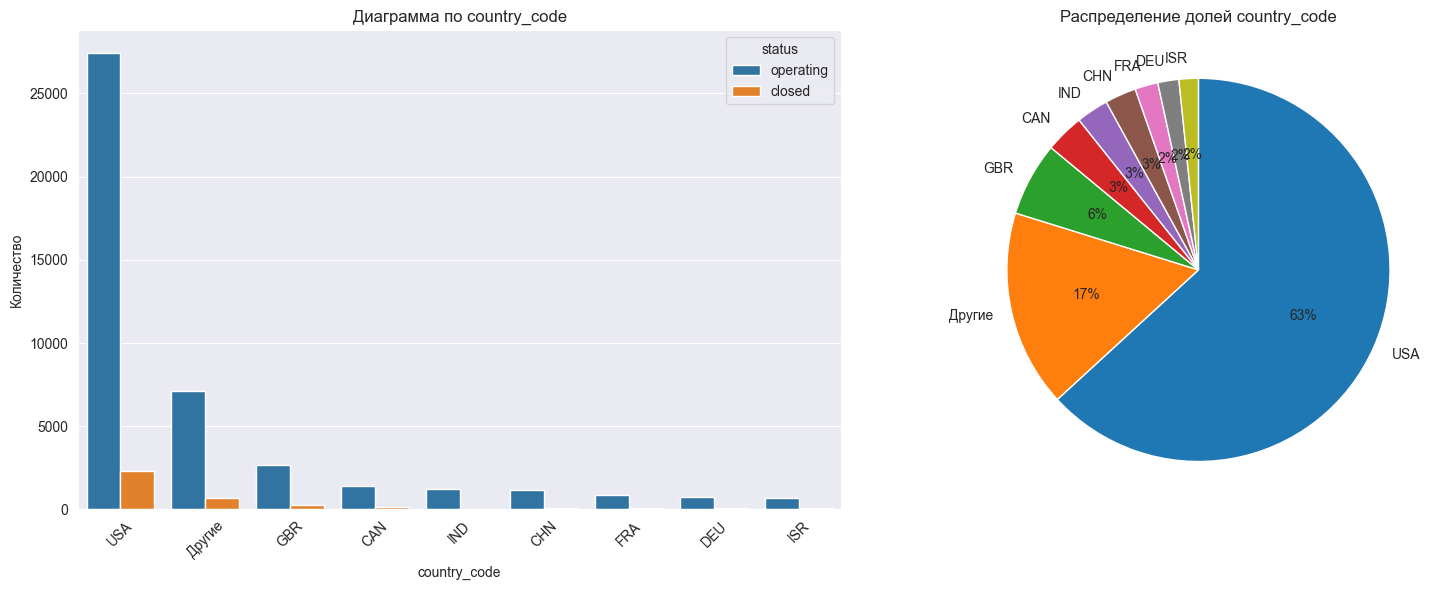

Визуализация категориального признака: state_code


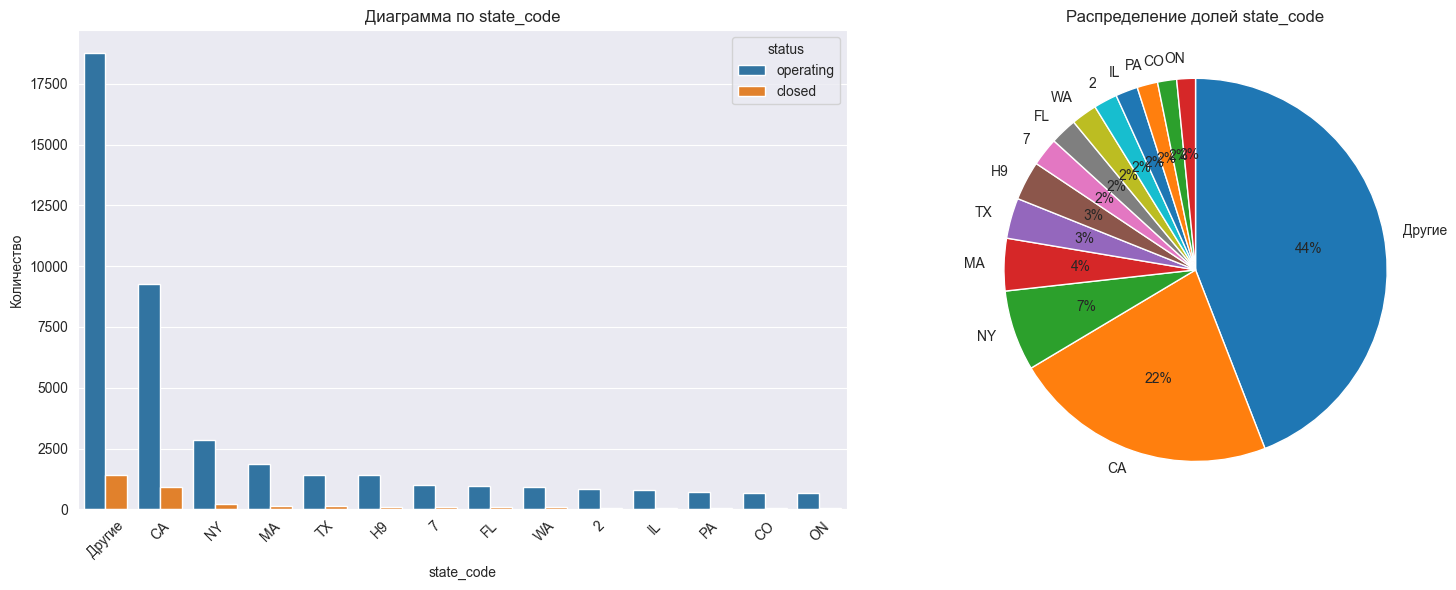

Визуализация категориального признака: region


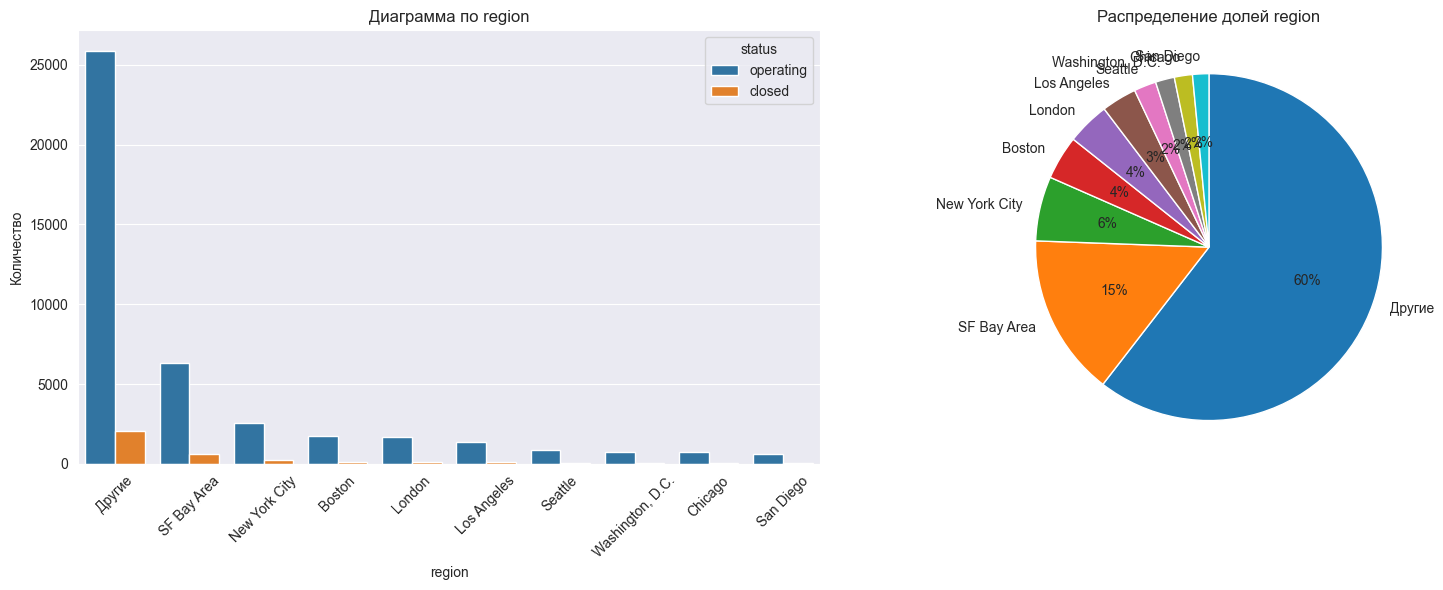

Визуализация категориального признака: city


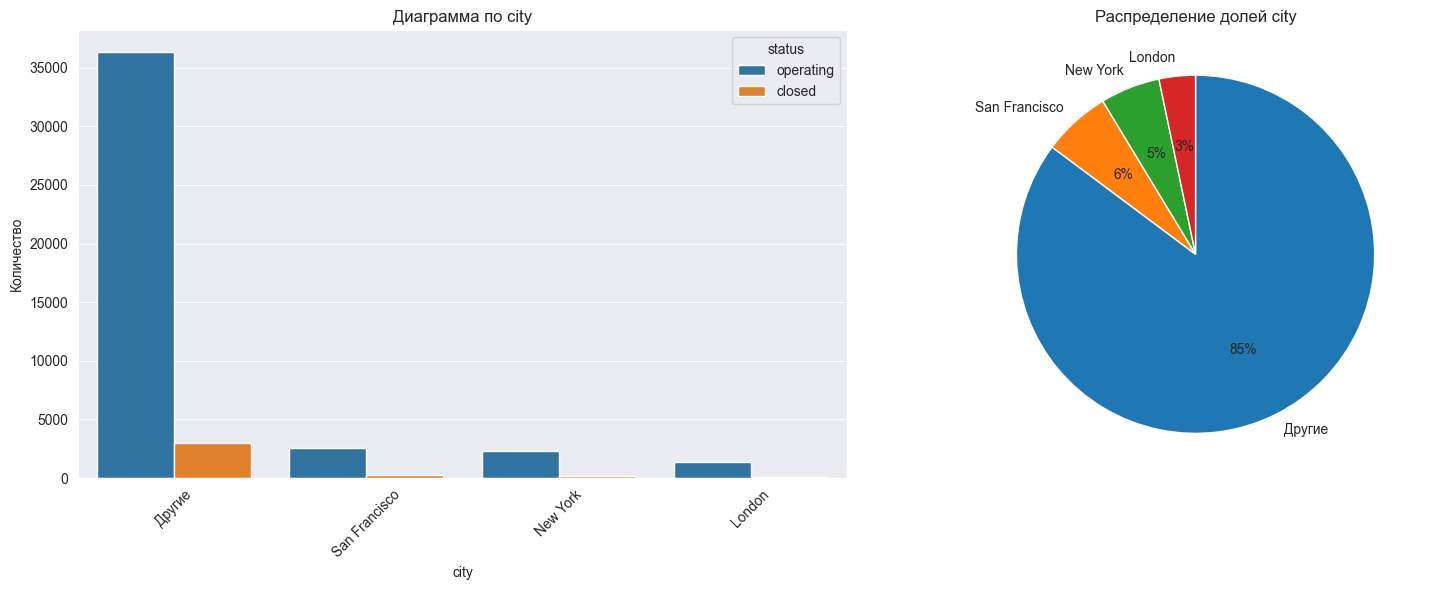

Визуализация категориального признака: cat_1


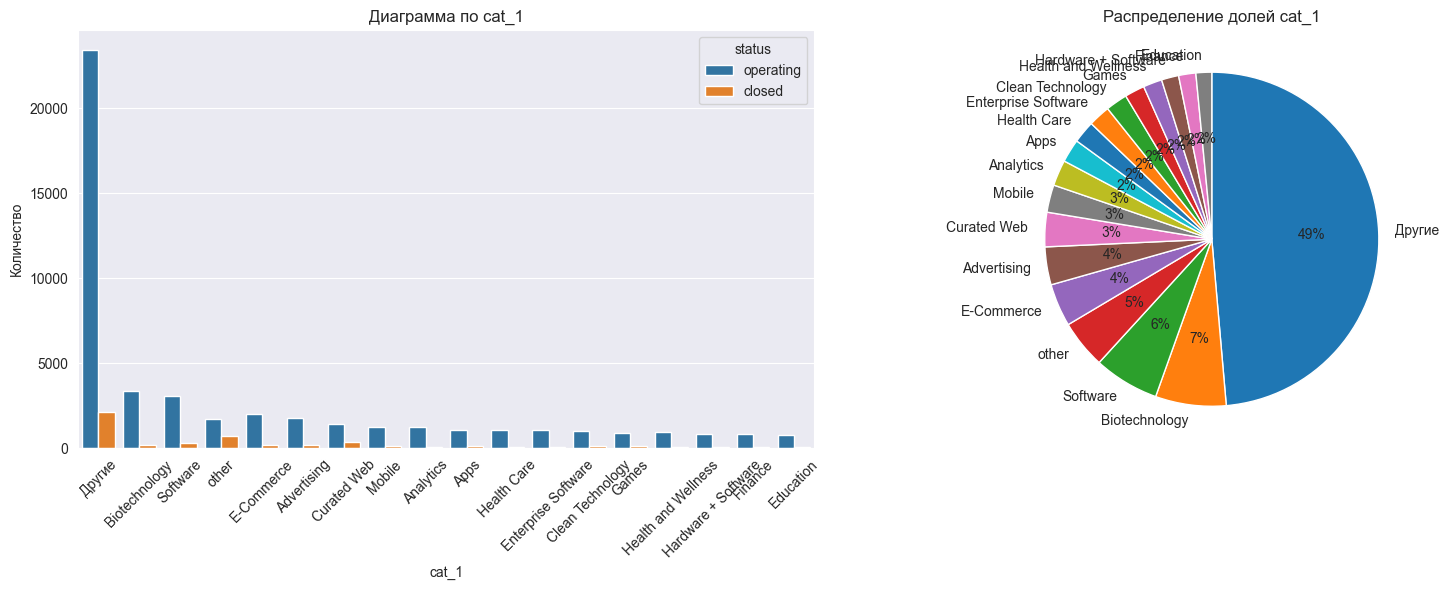

Визуализация категориального признака: cat_2


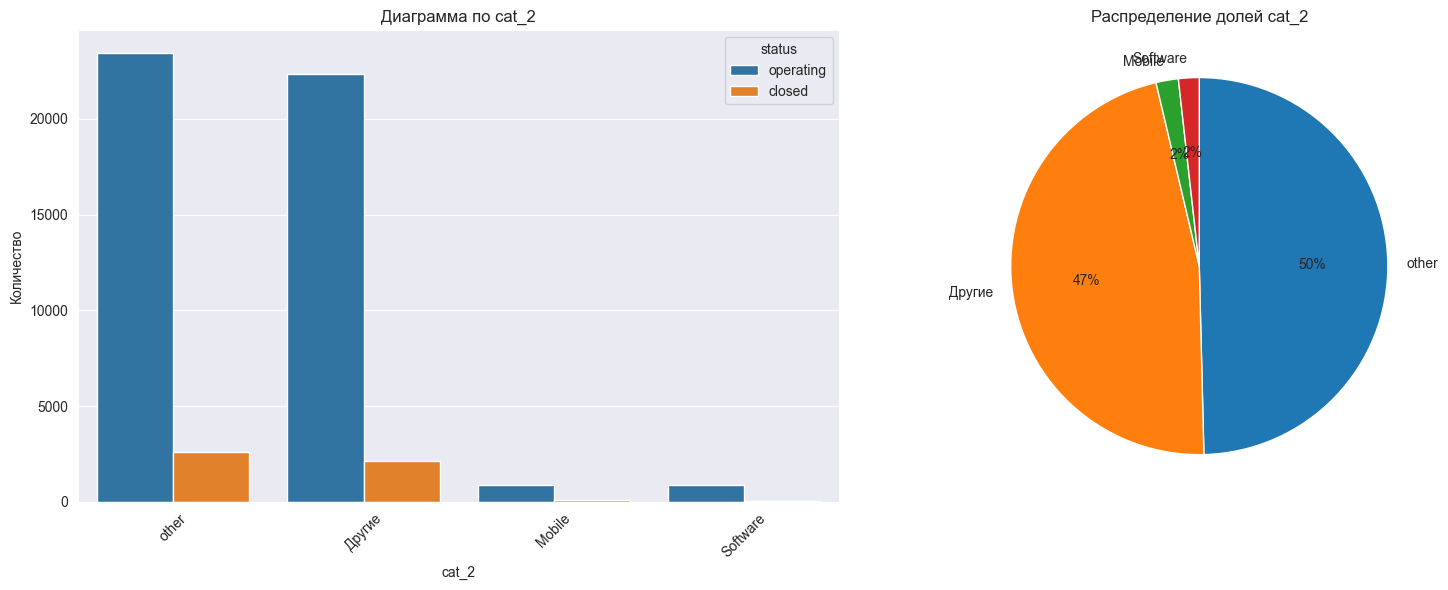

Визуализация категориального признака: cat_3


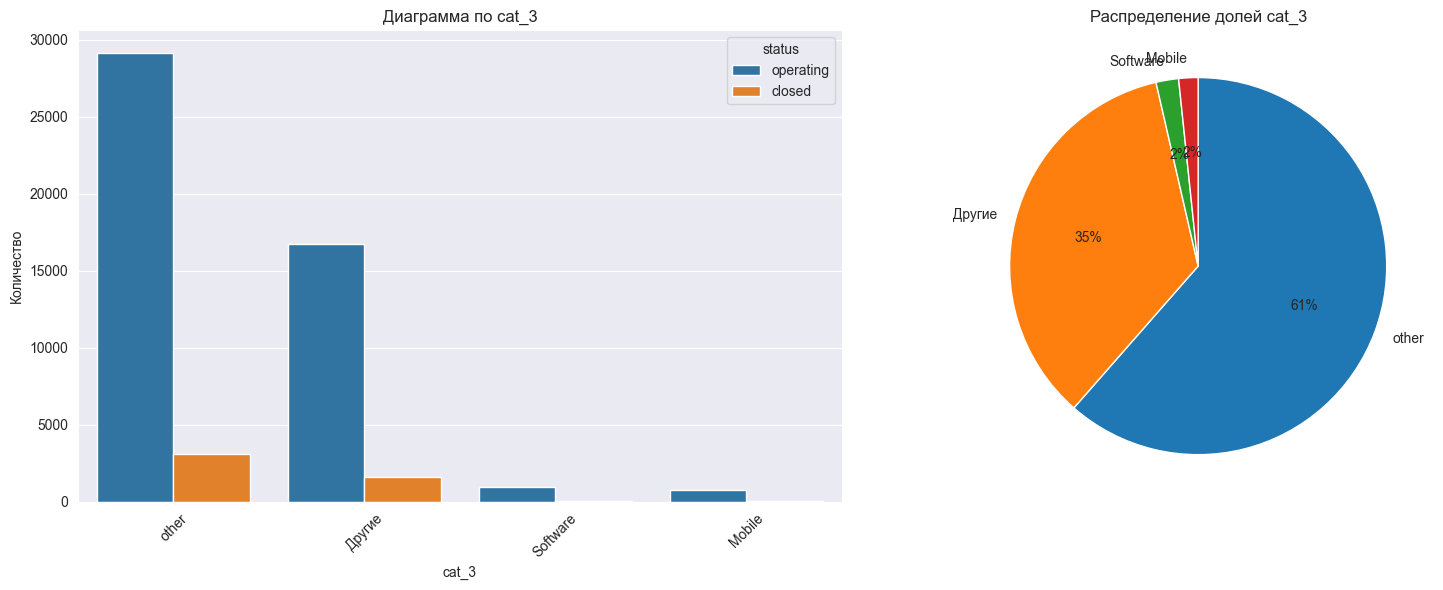

Визуализация категориального признака: cat_4


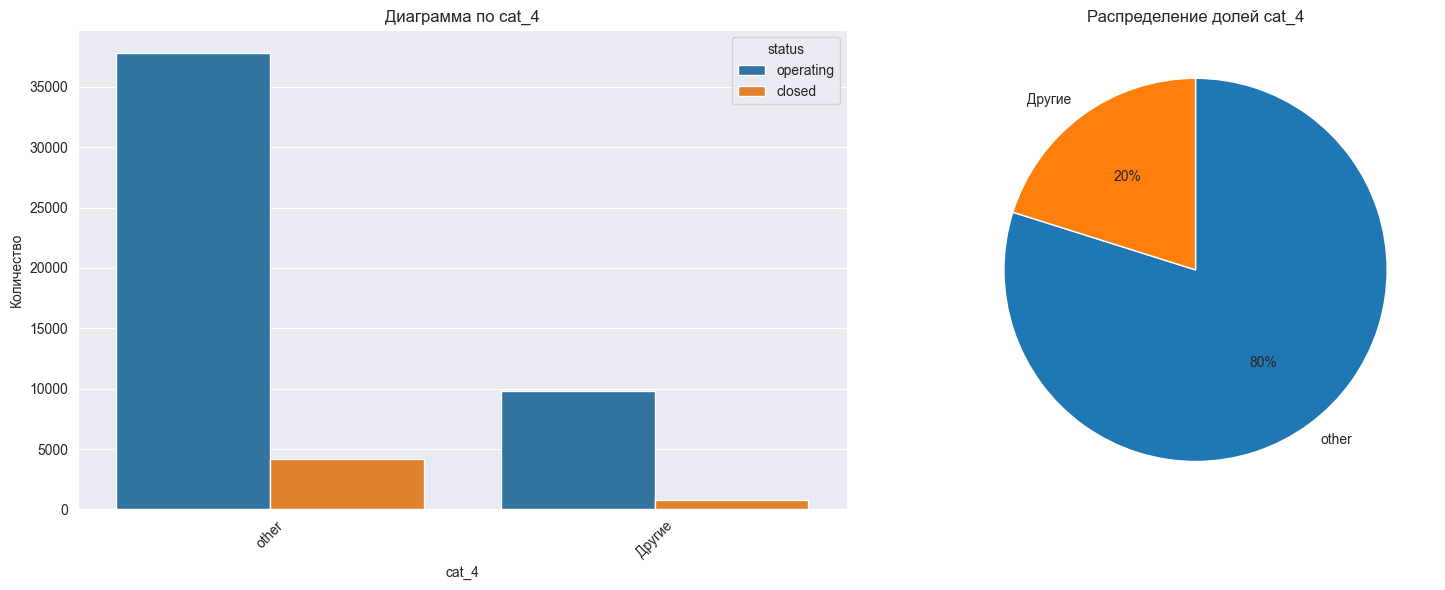

Визуализация категориального признака: cat_5


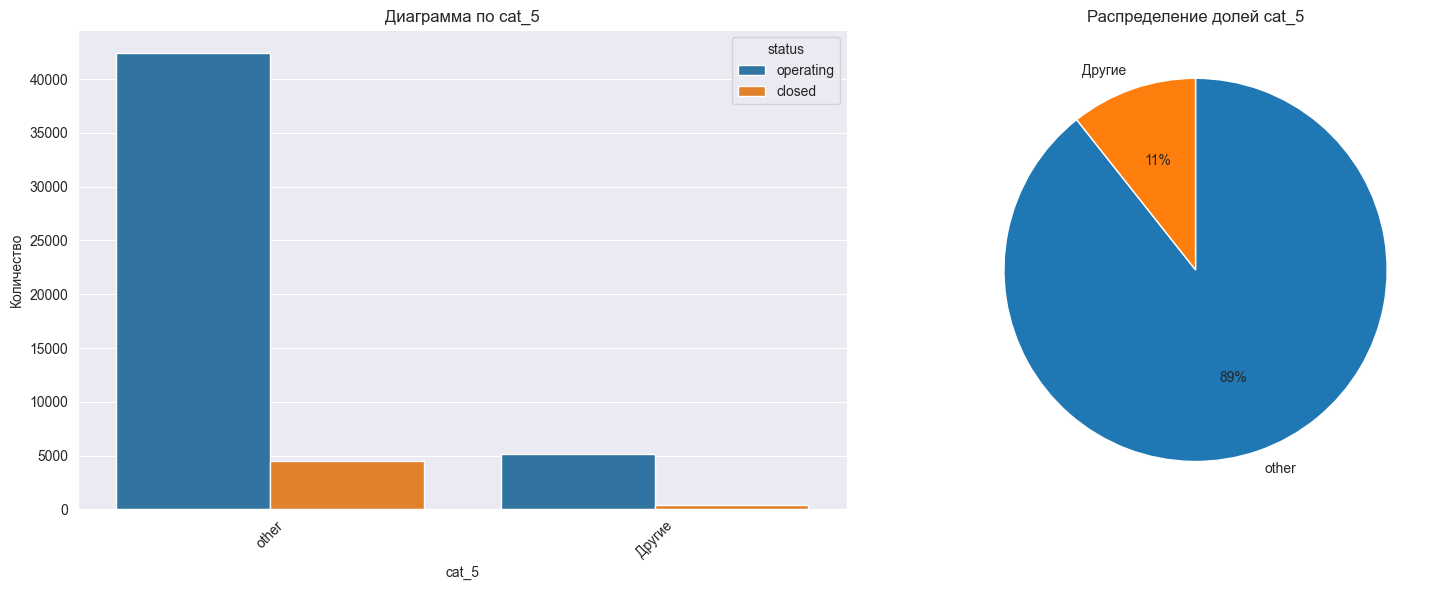

In [103]:
# Визуализируем категориальные признаки
all_diag(split_train, column_type='categorical', hue='status')

При построении графиков значения категориальных признаков занимающие менее 1,5% были собюраны в категорию 'Другие' для лучшей визуализации

- name - все значения уникальны, что ожидаемо
- status - целевой признак, по графику мы видим сильный дисбаланс классов, только 9% из всех стартапов закрылись.
- country_code - основная страна регистрации стартапов - США с долей 63%, затем идут Великобритания и Канада с 6 и 3%.
- state_code - самый распространенный штат регистрации стартапов - Калифорния, за ним идут Нью-Йорк и Массачусетс
- region - самый популярные регион это Область Залива Сан-Франциско и Нью-Йорк с 15% и 6% соответственно
- city - Сан Франциско, Нью-Йорк и Лондон самые популярные города для стартапов
- cat1 - В топе у нас программное обеспечение и биотехнологии
- cat2 - Тут програмное обеспечение и мобилки
- cat3 - Тоже самое
- cat4, cat5 - категории почти полность из уникальных значений и other

- Распределение целевой переменной примерно совпадает с распеределением всех признаков.

### 2.3. Анализ признаков с датами

In [104]:
# Создадим функцию для визуализации признаков дат
def date_diag(data, date_col, hue=None,
                          figsize=(12, 6)):

    df = data.copy()
    df['year'] = df[date_col].dt.year

    plt.figure(figsize=figsize)
    ax = sns.countplot(
        data=df,
        x='year',
        hue=hue,
        order=sorted(df['year'].unique())
    )

    for container in ax.containers:
        ax.bar_label(container, fmt='%d', padding=3)

    plt.title(f'Распределение данных по годам\n({date_col})')
    plt.xlabel('Год')
    plt.ylabel('Количество записей')
    plt.xticks(rotation=45)

    if hue:
        plt.legend(
            title=hue,
            bbox_to_anchor=(1.05, 1),
            loc='upper left',
            borderaxespad=0
        )

    plt.tight_layout()
    plt.show()

In [105]:
# Выберем все столбцы с датами
date_cols_train = split_train.select_dtypes(include=['datetime64']).columns
date_cols_test = split_test.select_dtypes(include=['datetime64']).columns

Визуализация категориального признака: founded_at


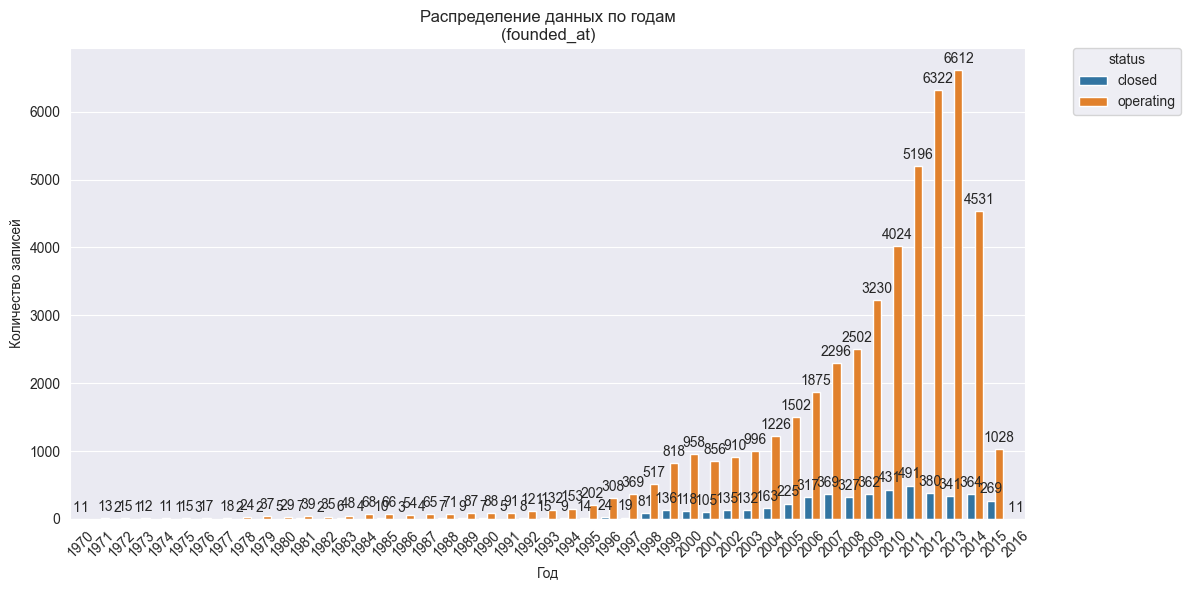

Визуализация категориального признака: first_funding_at


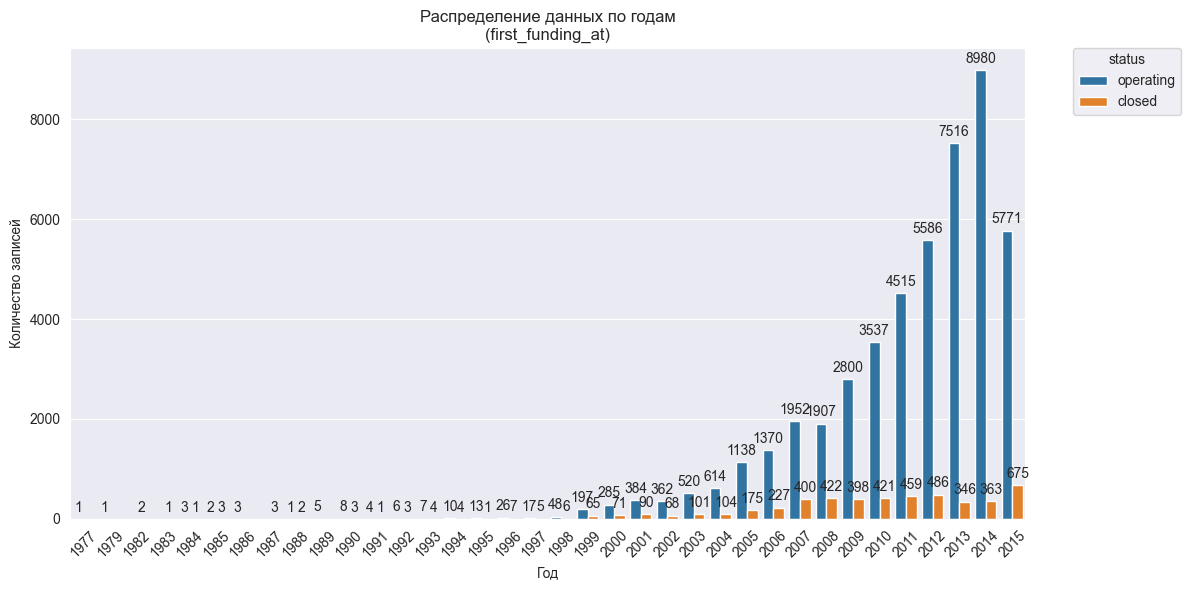

Визуализация категориального признака: last_funding_at


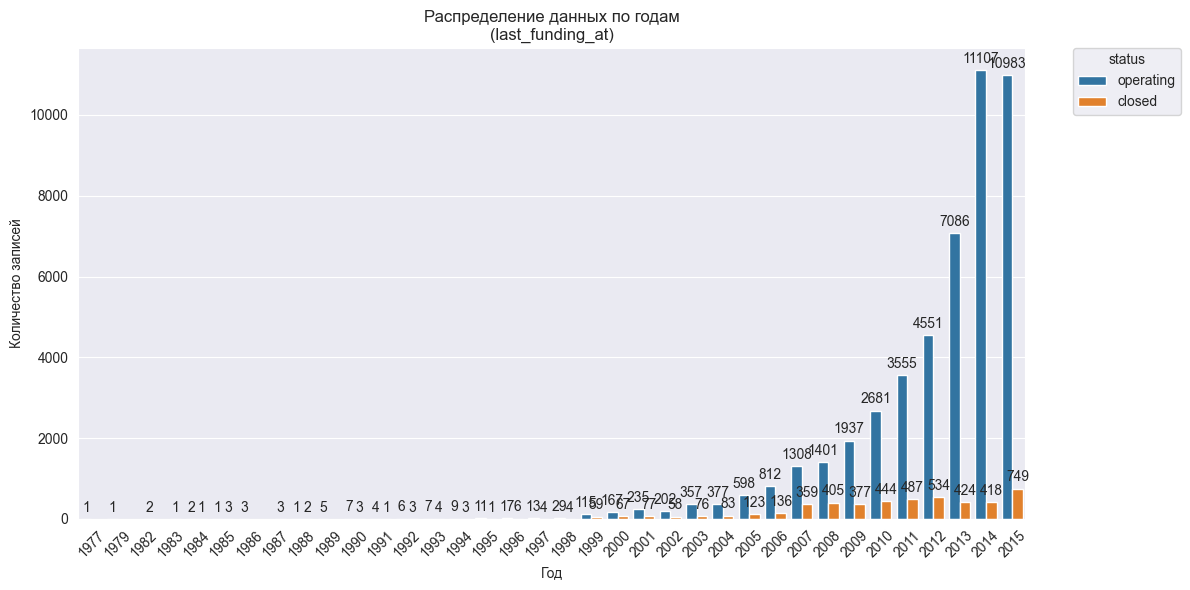

Визуализация категориального признака: closed_at


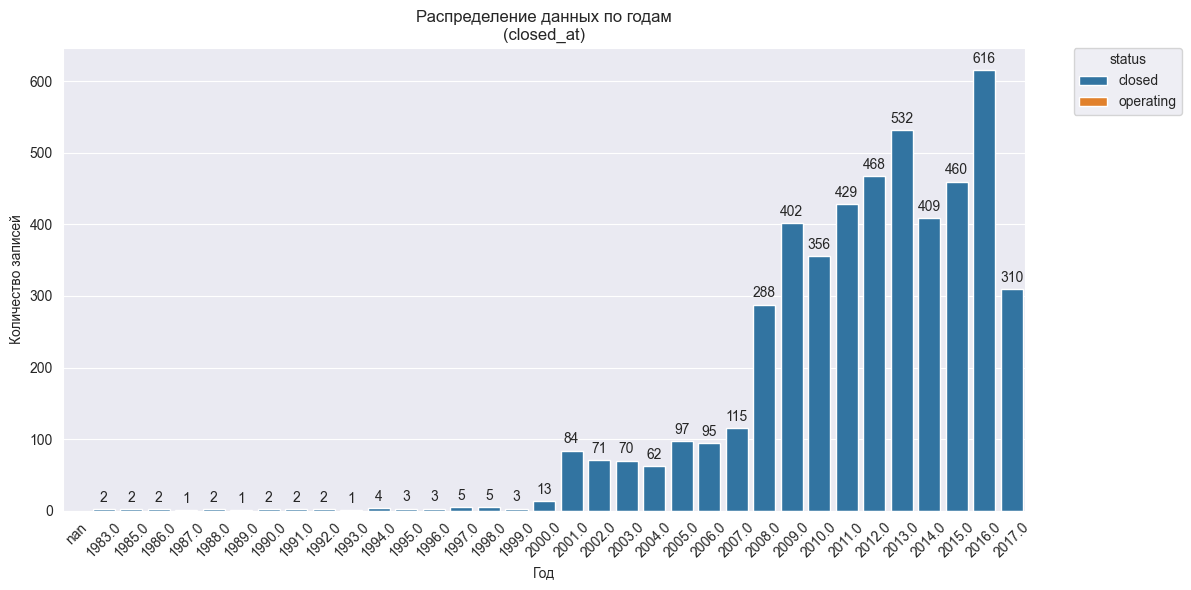

In [106]:
# Визуализируем даты
for date_col in date_cols_train:
    print(f"Визуализация категориального признака: {date_col}")
    date_diag(split_train, date_col, hue='status')

- founded_at - большинство стартапов было основано с 2005 по 2014 год, также в эти периоды приходится основная часть закрытия стартапов. Количество закрытий напрямую с количеством открытий не коррелирует. Максимальное количетво закрытых стартапов было в 2011 году а максимальное количество открытых в 2013.
- first_funding_at - распределение дат первого раунда финансирования совпадают с распределеним с созданием стартапов. Максимальное количество стартапов прошедших первых раундов финансирования было в 2014 году.
- last_funding_at - распределение дат последнего раунда финансирования также похожи на график основания стартапов. Максимальное количество дат посоледнего финансирования было в 2014 и 2015 годах
- closed_at - основное количество закрытия стартапов проходилось с 2008 по 2017 год
- основная активность финансирования, закрытия и открытия стартапов начинается с 90x-2000x годов, до этого активность минамальна



Создадим новые признаки на основе дат

In [107]:
# Создадим копии датафремов для обрабоки дат
date_train = split_train.copy()
date_test = split_test.copy()

In [108]:
# Зададим дату выгрузки датасета
exp_date = pd.to_datetime('2018-01-01')

In [109]:
# Заполним пропуски в столбце closed_at датой выгрузки
date_train['closed_at'] = date_train['closed_at'].fillna(exp_date)

In [110]:
# Создадим стобец lifetime как разницу между датой основания стартапа и разницей закрытия в днях
date_train['lifetime'] = (date_train['closed_at'] - date_train['founded_at']).dt.days

In [111]:
# Создадим столбец разницы между первым и последним финансированием в днях
date_train['fundingtime'] = (date_train['last_funding_at'] - date_train['first_funding_at']).dt.days
date_test['fundingtime'] = (date_test['last_funding_at'] - date_test['first_funding_at']).dt.days

In [112]:
# Создадим столбец разницы между первым финансированием и датой выгрузки в днях
date_train['lastf_expd'] = (exp_date - date_train['last_funding_at']).dt.days
date_test['lastf_expd'] = (exp_date - date_test['last_funding_at']).dt.days

In [113]:
# Создадим столбец разницы между последним финансированием и датой выгрузки в днях
date_train['firstf_expd'] = (exp_date - date_train['first_funding_at']).dt.days
date_test['firstf_expd'] = (exp_date - date_test['first_funding_at']).dt.days

In [114]:
date_cols_train

Index(['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at'], dtype='object')

In [115]:
date_cols_test

Index(['first_funding_at', 'last_funding_at'], dtype='object')

In [116]:
# Удалим столбцы с датами из датасетов, больше они нам не нужны
date_train = date_train.drop(columns=date_cols_train)
date_test = date_test.drop(columns=date_cols_test)

In [117]:
# Проверка
print(split_train.shape)
print(split_test.shape)
print(date_train.shape)
print(date_test.shape)

(52506, 16)
(13125, 14)
(52506, 16)
(13125, 15)


In [118]:
# Сформируем список новых колонок для анализа
date_diff = ['lifetime',
            'fundingtime',
            'lastf_expd',
            'firstf_expd']

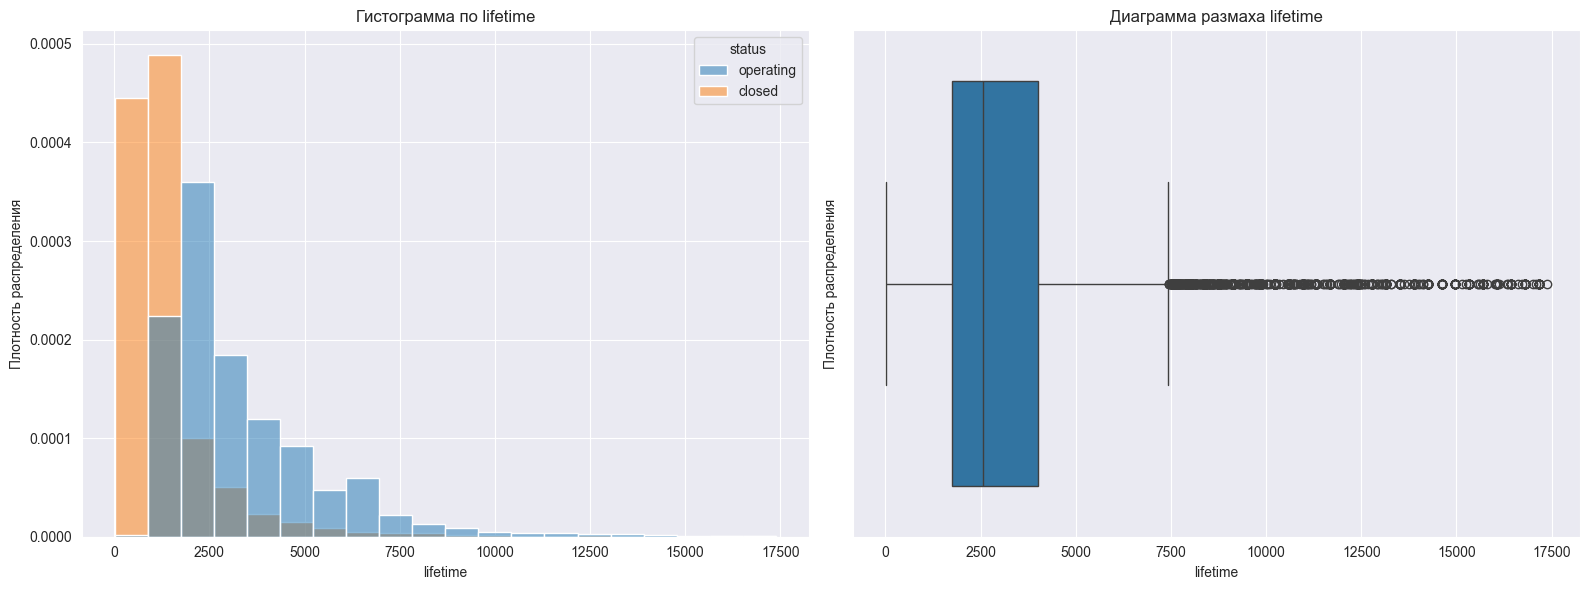

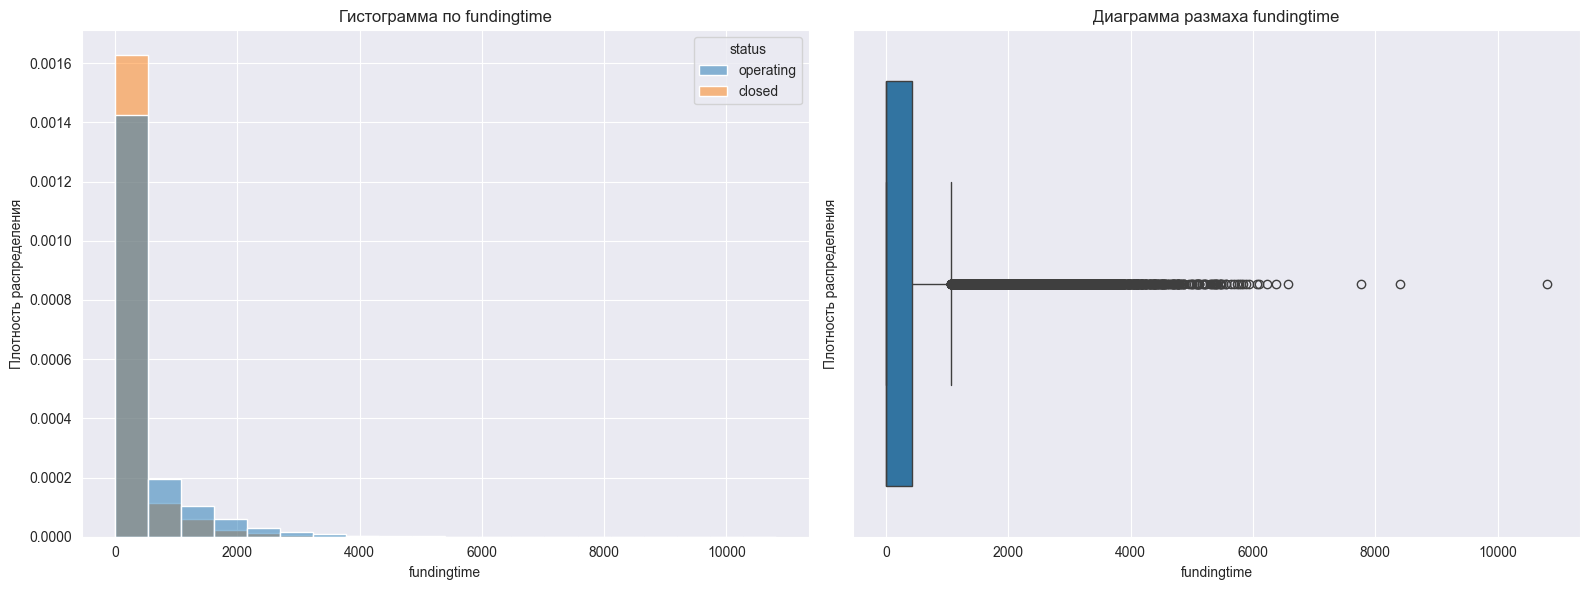

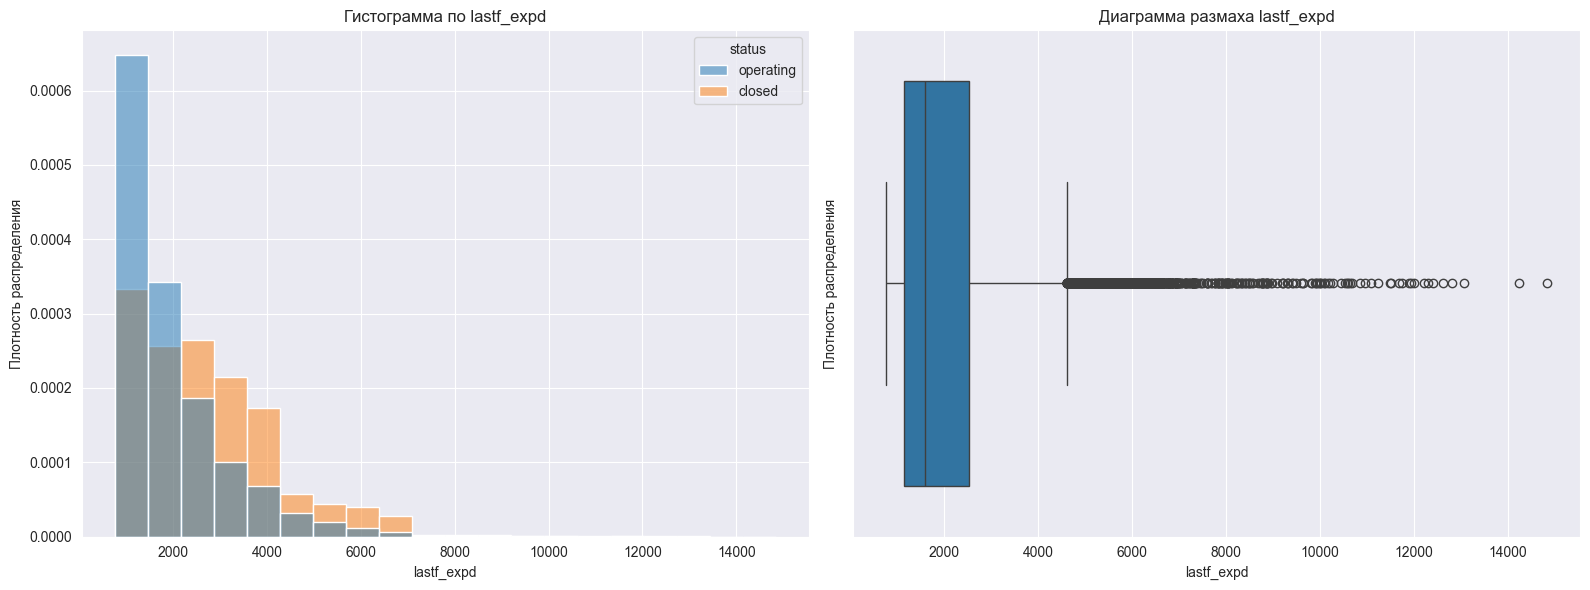

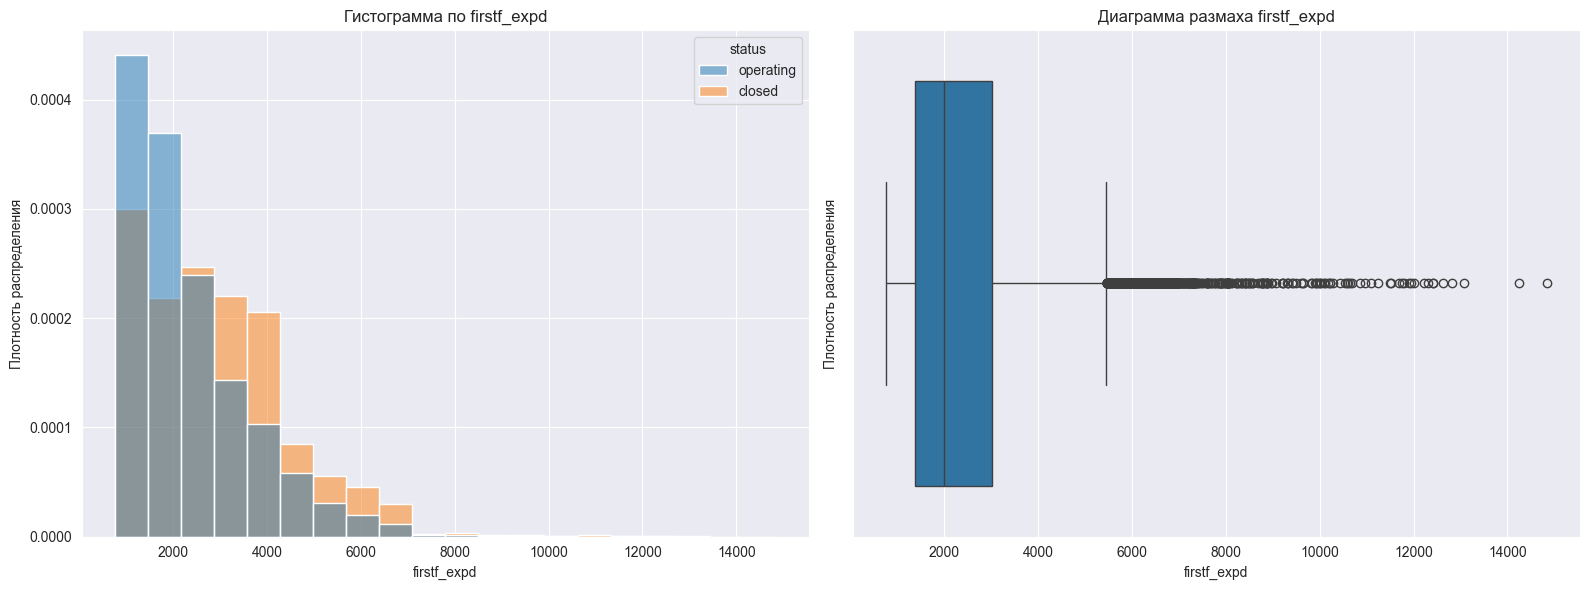

In [119]:
# Построим графики новых колонок
for col in date_diff:
    num_diag(date_train, x=col, xlabel=col, ylabel='Плотность распределения', hue='status')

In [120]:
date_train['lifetime'].describe()

count   52506.00
mean     3141.10
std      2147.92
min        19.00
25%      1739.00
50%      2557.00
75%      4018.00
max     17378.00
Name: lifetime, dtype: float64

- lifetime - стартапы закрываются в первые 1,5-2 тыс. дней, основная часть работающих стартапов просуществовало уже 2,5-3 тыс дней. Важный признак.

In [121]:
date_train['fundingtime'].describe()

count   52506.00
mean      346.55
std       688.65
min         0.00
25%         0.00
50%         0.00
75%       427.00
max     10807.00
Name: fundingtime, dtype: float64

- fundingtime - время финансирования стартапов примерно год.

In [122]:
date_train['lastf_expd'].describe()

count   52506.00
mean     2013.40
std      1222.66
min       756.00
25%      1141.00
50%      1585.00
75%      2526.00
max     14841.00
Name: lastf_expd, dtype: float64

- lastf_expd - на графике можно увидеть, что разница между датой выгрузки и датой последнего финансирования для большинства работающих стартапов меньше чем для закрытых. Это логично т.к. если стартап недавно финансировали то он скорее всего работает. Важный признак.

In [123]:
date_train['firstf_expd'].describe()

count   52506.00
mean     2359.95
std      1323.39
min       758.00
25%      1371.00
50%      1990.00
75%      3004.50
max     14841.00
Name: firstf_expd, dtype: float64

### 2.4. Анализ признаков с локациями

Обработаем датасет city перед началом анализа

In [124]:
# Создадим копии перед обработкой
loc_train = date_train.copy().reset_index()
loc_test = date_test.copy().reset_index()

In [125]:
# Предварительно удалим дубликаты городов с одинаковым названием, оставим только самые крупные
city_filtered = city.sort_values('Population', ascending=False).drop_duplicates(subset=['City'])

In [126]:
# Уберем из названий не английские буквы
loc_train['city'] = loc_train['city'].apply(
    lambda x: unidecode(str(x)) if pd.notna(x) else '')
loc_test['city'] = loc_train['city'].apply(
    lambda x: unidecode(str(x)) if pd.notna(x) else '')

In [127]:
# Приведем все значения к нижнему регистру
loc_train['city'] = loc_train['city'].str.lower()
loc_test['city'] = loc_test['city'].str.lower()

In [128]:
# Объединяем датасет с городами с датасетом train
merged_train = pd.merge(
    loc_train,
    city_filtered,
    left_on=['city'],
    right_on=['City'],
    how='left'
)

In [129]:
# Объединяем датасет с городами с датасетом test
merged_test = pd.merge(
    loc_test,
    city_filtered,
    left_on=['city'],
    right_on=['City'],
    how='left'
)

In [130]:
print(loc_train.shape)
print(loc_test.shape)
print(merged_train.shape)
print(merged_test.shape)


(52506, 17)
(13125, 16)
(52506, 24)
(13125, 23)


In [131]:
# Посмотрим на получившийся датасет
overview_data(merged_train)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52506 entries, 0 to 52505
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52505 non-null  object 
 1   funding_total_usd  42445 non-null  float64
 2   status             52506 non-null  object 
 3   country_code       47010 non-null  object 
 4   state_code         45749 non-null  object 
 5   region             46153 non-null  object 
 6   city               52506 non-null  object 
 7   funding_rounds     52506 non-null  int64  
 8   cat_1              52506 non-null  object 
 9   cat_2              52506 non-null  object 
 10  cat_3              52506 non-null  object 
 11  cat_4              52506 non-null  object 
 12  cat_5              52506 non-null  object 
 13  lifetime           52506 non-null  

Почти все города заполнились правильно

Проанализируем столбец с населением, по столбцам с широтой и долготой будет сложно что-либо понять.

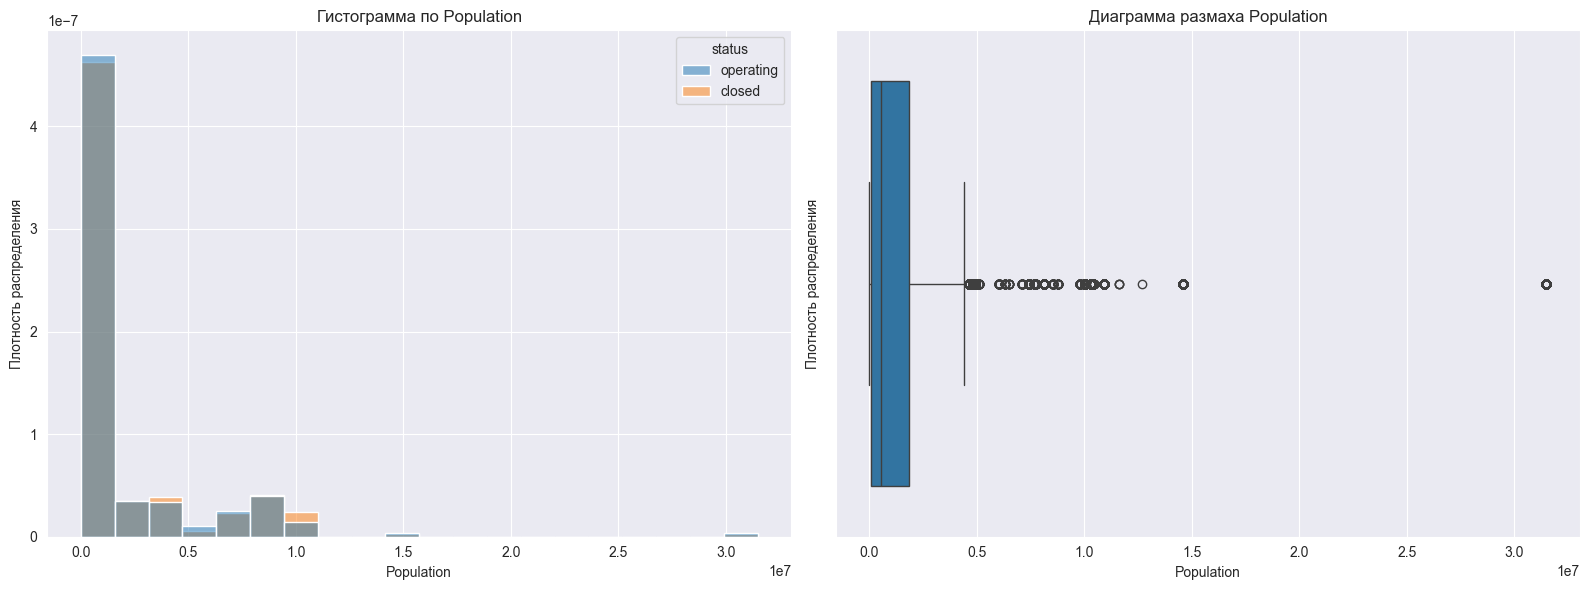

In [132]:
num_diag(merged_train, x='Population', xlabel='Population', ylabel='Плотность распределения', hue='status')

In [133]:
merged_train[('Population')].describe()

count      41042.00
mean     1989114.59
std      3620879.85
min          251.00
25%        89326.00
50%       540513.00
75%      1843459.00
max     31480498.00
Name: Population, dtype: float64

- Population - восновном стартапы открывались в городах среднего размера.

In [134]:
# Удалим все лишние колонки из обоих датасетов
merged_train = merged_train.drop(columns=['Country', 'City', 'AccentCity', 'Region', 'state_code', 'region', 'city', 'country_code']).set_index('name')
merged_test = merged_test.drop(columns=['Country', 'City', 'AccentCity', 'Region', 'state_code', 'region', 'city', 'country_code']).set_index('name')

In [135]:
# Проверка
print(loc_train.shape)
print(loc_test.shape)
print(merged_train.shape)
print(merged_test.shape)

(52506, 17)
(13125, 16)
(52506, 15)
(13125, 14)


### Вывод

## 3. Корреляционный анализ

### 3.1. Матрица корреляций

In [136]:
# Вычислим матрицу Phik для всего датафрейма
phk = merged_train.phik_matrix(verbose=False)

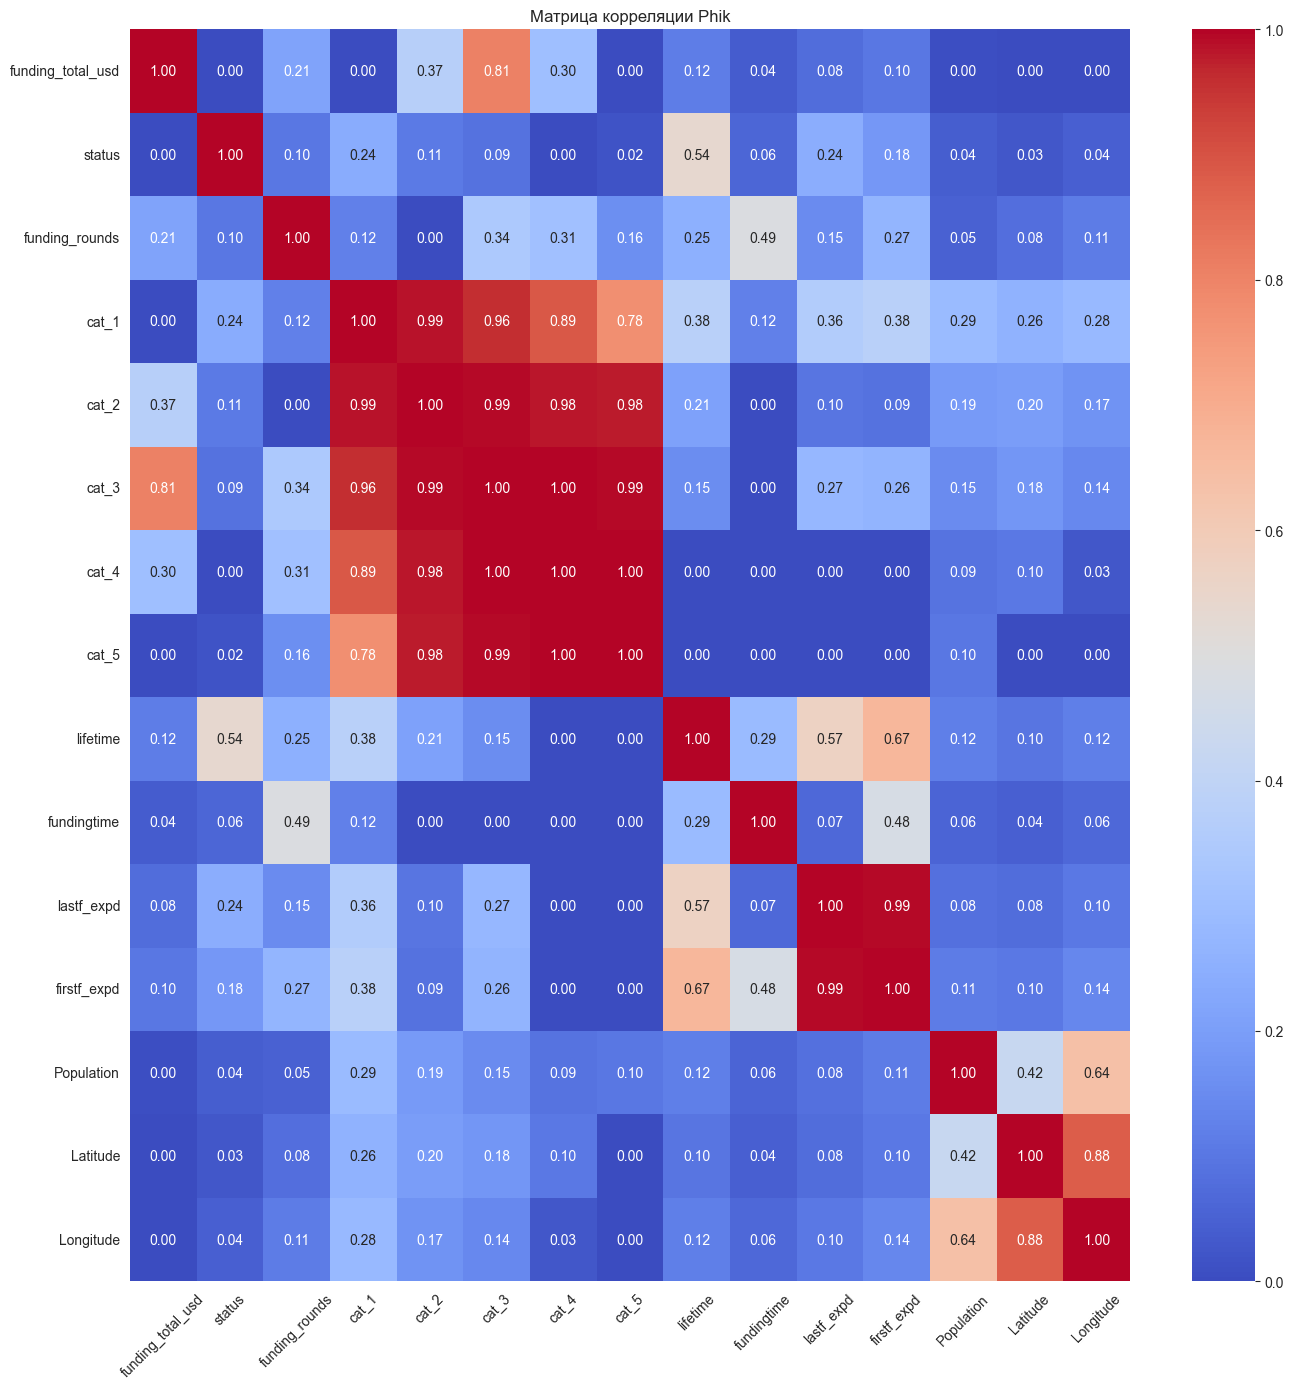

In [137]:
# Визуализируем
plt.figure(figsize=(14, 14))
plt.title('Матрица корреляции Phik')
sns.heatmap(phk, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Сильные корреляции (близкие к 1.0):

- cat_1, cat_2, cat_3, cat_4, cat_5 между собой сильно коррелируют. Разделяли ячейки и заменяли пропуски одним значением.
- firstf_expd и lastf_expd (0.99) — скорее всего из-за того что по многим стартапам нет данных по финансированию
- Latitude и Longitude (0.88) — ожидаемо, поскольку координаты географически связаны.

Средние корреляции (0.4 - 0.7):

- lifetime и firstf_expd (0.67) — возраст компании может быть связан с первым раундом финансирования.
- Population и Longitude (0.64) — возможно, компании чаще создаются в определенных регионах.

Слабые корреляции (ниже 0.3):

funding_total_usd имеет слабую связь с большинством переменных, кроме cat_3 (0.81) и cat_2 (0.37), скорее всего некоторые отрасли финансируются лучше.


- lastf_expd и firstf_expd сильно коррелируют между собой, удалим firstf_expd т.к. она хуже коррелирует с целевой перемененой
- cat_1, cat_2, cat_3, cat_4, cat5 - все сильно коррелируют между собой, оставим ту которая лучше коррелирует с целевой переменой - cat_1

In [138]:
merged_train = merged_train.drop(columns=['cat_2', 'cat_3', 'cat_4', 'cat_5', 'firstf_expd'])
merged_test = merged_test.drop(columns=['cat_2', 'cat_3', 'cat_4', 'cat_5', 'firstf_expd'])

### 3.2 Мультиколлинеарность

In [139]:
# Добавим константу
train_with_const = merged_train.select_dtypes(include=['number'])
train_with_const = add_constant(train_with_const)

In [140]:
# Определим функцию подсчета VIF
def calc_vif(df):

    vif_data = pd.DataFrame()
    vif_data["variables"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    return vif_data

In [141]:
# Рассчитаем VIF
train_with_const = train_with_const.dropna()
calc_vif(train_with_const)

,variables,VIF
0,const,14.85
1,funding_total_usd,1.02
2,funding_rounds,2.43
3,lifetime,1.39
4,fundingtime,2.57
5,lastf_expd,1.33
6,Population,1.20
7,Latitude,1.02
8,Longitude,1.22


- lastf_expd и firstf_expd сильно коррелируют между собой, удалим firstf_expd т.к. она хуже коррелирует с целевой перемененой
- cat_1, cat_2, cat_3, cat_4, cat5 - все сильно коррелируют между собой, оставим ту которая лучше коррелирует с целевой переменой - cat_1

Ключевые пороги для VIF:
- VIF < 5: Минимальная мультиколлинеарность, это нормально.
- 5 ≤ VIF ≤ 10: Признак умеренной мультиколлинеарности, стоит обратить внимание.
- VIF > 10: Сильная мультиколлинеарность, вероятно, данные коррелируют с другими, стоит рассмотреть их исключение или трансформацию.

### Вывод

## 4. Моделирование

In [142]:
# Сделаем копии датасетов перед моделированием
data_train = merged_train.copy().reset_index()
data_test = merged_test.copy().reset_index()

In [143]:
# Посмотрим на полученный датасет
overview_data(data_train)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52506 entries, 0 to 52505
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52505 non-null  object 
 1   funding_total_usd  42445 non-null  float64
 2   status             52506 non-null  object 
 3   funding_rounds     52506 non-null  int64  
 4   cat_1              52506 non-null  object 
 5   lifetime           52506 non-null  int64  
 6   fundingtime        52506 non-null  int64  
 7   lastf_expd         52506 non-null  int64  
 8   Population         41042 non-null  float64
 9   Latitude           45696 non-null  float64
 10  Longitude          45696 non-null  float64
dtypes: float64(4), int64(4), object(3)
memory usage: 4.4+ MB
None


--------------------------------------------------
Первые строки да

In [144]:
# Определим числовые и категориальные колонки
numeric_features = data_train.select_dtypes(include=['number']).columns.difference(['status']).tolist()
categorical_features = data_train.select_dtypes(include=['object']).columns.difference(['status', 'name']).tolist()

In [145]:
categorical_features

['cat_1']

In [146]:
numeric_features

['Latitude',
 'Longitude',
 'Population',
 'funding_rounds',
 'funding_total_usd',
 'fundingtime',
 'lastf_expd',
 'lifetime']

In [147]:
# Изменим тип строковых колонок на категориальный
data_train[categorical_features] = data_train[categorical_features].astype('category')
data_test[categorical_features] = data_test[categorical_features].astype('category')

In [148]:
# Закодируем целевой признак
le = LabelEncoder()
data_train['status'] = le.fit_transform(data_train['status'])

In [149]:
# Отделим целевой признак от обучающей выборки
X = data_train.drop(columns=['status', 'name'])
y = data_train['status']

In [150]:
# Разделим датасет на тренировочные и валидационные данные
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = y
)

In [151]:
# Функция для превращения входного массива обратно в датафрейм
def to_dataframe(X):
    return pd.DataFrame(X)

In [152]:
# Создадим трансформер для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [153]:
# Создадим трансформер для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='other')),
    ('encoder', CatBoostEncoder())
])

In [154]:
# Препроцессор для всех признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [155]:
# Сделаем данные датафреймом после трансформера
postprocessor = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_df', FunctionTransformer(to_dataframe, feature_names_out='one-to-one'))
])

In [156]:
# Создадим пайплайн
pipeline = Pipeline([
    ('preprocessor', postprocessor),
    ('classifier', CatBoostClassifier())
])


In [161]:
# Модели и параметры для перебора
param_grid = [
    {
        'classifier': [LGBMClassifier(random_state=RANDOM_STATE,
                                    class_weight='balanced',
                                    objective='binary')],
        'classifier__n_estimators': [100, 300, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__num_leaves': [31, 63, 127],
        'classifier__max_depth': [5, 10, -1],
        'classifier__min_child_samples': [10, 20, 50],
        'classifier__feature_fraction': [0.6, 0.8, 1.0],
        'classifier__bagging_fraction': [0.6, 0.8, 1.0],
        'classifier__bagging_freq': [0, 1, 5],
        'classifier__verbose': [-1]
    },
    {
        'classifier': [CatBoostClassifier(random_state=RANDOM_STATE,
                                        auto_class_weights='Balanced',
                                        silent=True)],
        'classifier__iterations': [50, 100, 200],
        'classifier__depth': [8, 10, 12],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__l2_leaf_reg': [1, 3, 5]
    }
]

In [162]:
# Создадим скорер, нам нужно определять закрытые стартапы
f1_scorer = make_scorer(f1_score, pos_label=0)

In [163]:
# Определим случайный перебор параметров и моделей
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=40,
    cv=5,
    scoring=f1_scorer,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=2,
    refit=True
)

In [164]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              Pipeline(steps=[('preprocessor',
                                                               ColumnTransformer(transformers=[('num',
                                                                                                Pipeline(steps=[('imputer',
                                                                                                                 SimpleImputer(strategy='median')),
                                                                                                                ('scaler',
                                                                                                                 StandardScaler())]),
                                                                                                ['Latitude',
                                                                                                 'Longitude',
                                                                                                 'Population',
                                                                                                 'funding_rounds',
                                                                                                 'funding_total_usd',
                                                                                                 'fundingtime',
                                                                                                 'lastf_expd',
                                                                                                 'lifetime']),
                                                                                               ('cat',
                                                                                                P...
                                         'classifier__num_leaves': [31, 63,
                                                                    127],
                                         'classifier__verbose': [-1]},
                                        {'classifier': [<catboost.core.CatBoostClassifier object at 0x3353ca790>],
                                         'classifier__depth': [8, 10, 12],
                                         'classifier__iterations': [50, 100,
                                                                    200],
                                         'classifier__l2_leaf_reg': [1, 3, 5],
                                         'classifier__learning_rate': [0.01,
                                                                       0.05,
                                                                       0.1]}],
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict', pos_label=0),
                   verbose=2)

In [165]:
# Выведем лучшую модель
print('Лучшая модель и её параметры:', random_search.best_estimator_)

Лучшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Latitude',
                                                                    'Longitude',
                                                                    'Population',
                                                                    'funding_rounds',
                                                                    'fu

In [168]:
# Метрики модели на валидационной выборке выборке
y_val_pred = random_search.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.92      0.83      0.87      1229
           1       0.98      0.99      0.99     11898

    accuracy                           0.98     13127
   macro avg       0.95      0.91      0.93     13127
weighted avg       0.98      0.98      0.98     13127



In [170]:
# Обучим лучшую модель на всех данных
best_pipeline = random_search.best_estimator_
best_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Latitude',
                                                                    'Longitude',
                                                                    'Population',
                                                                    'funding_rounds',
                                                                    'funding_total_usd',
                                                                    'fundingtime',
                                                                    'lastf_expd',
                                                                    'lifetime']),
                                                                  ('cat',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleIm...
                                                                                                  strategy='constant')),
                                                                                   ('encoder',
                                                                                    CatBoostEncoder())]),
                                                                   ['cat_1'])])),
                                 ('to_df',
                                  FunctionTransformer(feature_names_out='one-to-one',
                                                      func=<function to_dataframe at 0x158141a80>))])),
                ('classifier',
                 LGBMClassifier(bagging_fraction=1.0, bagging_freq=1,
                                class_weight='balanced', feature_fraction=0.8,
                                n_estimators=500, num_leaves=63,
                                objective='binary', random_state=42,
                                verbose=-1))])

In [ ]:
with open('model_startup.pkl', 'wb') as file:
    pickle.dump(model, file)

In [171]:
# Метрики модели на тестовой выборке выборке
# Метрики модели на валидационной выборке выборке
y_test_pred = best_pipeline.predict(data_test)

In [172]:
data_test['status'] = y_test_pred

In [173]:
submit = data_test[['name', 'status']].copy()

In [174]:
submit['status'] = le.inverse_transform(submit['status'])

In [175]:
# Генерируем строку с текущей датой и временем
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Сохраняем файл с автоматическим именем
filename = f"submit_{current_time}.csv"
submit.to_csv(filename, index=False)

print(f"Файл сохранен как: {filename}")

Файл сохранен как: submit_2025-04-05_11-34-55.csv


In [176]:
submit.head(100)

,name,status
0,Crystalsol,operating
1,JBI Fish & Wings,operating
2,COINPLUS,operating
3,Imagine Communications,operating
4,DNA13,operating
...,...,...
95,Slipstream,closed
96,Peak 10,operating
97,Theatro,operating
98,BurstPoint Networks,operating


In [177]:
submit.shape

(13125, 2)

In [178]:
# Сохраним лучшую модель
model = best_pipeline.named_steps['classifier']
preprocessor = best_pipeline.named_steps['preprocessor']

In [179]:
# Извлекаем данные после preprocessor
X_test_transformed = preprocessor.transform(X_val)

In [180]:
feature_names = preprocessor.get_feature_names_out()

In [181]:
# превращаем обратно в DataFrame с именами
X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_val)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

In [182]:
explainer = shap.Explainer(best_pipeline.named_steps['classifier'],
                                feature_names=feature_names)

In [183]:
# Получаем SHAP значения
shap_values = explainer(X_test_transformed_df)

/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


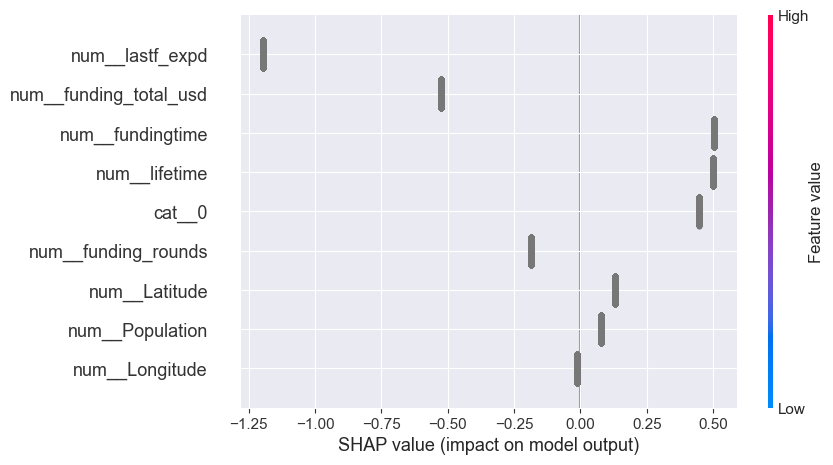

In [184]:
 # Визуализируем beeswarm-график для SHAP значений
shap.plots.beeswarm(shap_values, max_display=300)